# Group 14 - Phase 3 - Data Cleaning
* Andrei Oprea (1768905)
* Syeni Edith Perea Zelaya (2064936)
* Yujie Zhang (1817787)

In [1]:
import pandas as pd
import pm4py

In [6]:
data_raw = pm4py.read_xes('/Users/syeniperea/Desktop/PROFESIONAL/TUE/prom-lite-1.4-all-platforms/RETO FILES/BPI Challenge 2017.xes')


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [7]:
# Let's only consider the complete lifecycle:transition, this is because the value "complete" meaning
# the ongoing single event task is finished instead of being suspended or withdrawal, increasing the possibility to
# get more complete traces for our prediction

data_raw = data_raw[data_raw['lifecycle:transition'] == 'complete']

In [8]:
log = pm4py.convert_to_event_log(data_raw)

/usr/local/lib/python3.9/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [9]:
pm4py.get_end_activities(log)

{'A_Pending': 10288,
 'W_Validate application': 4036,
 'O_Cancelled': 14051,
 'O_Refused': 1977,
 'W_Call incomplete files': 631,
 'A_Cancelled': 119,
 'W_Complete application': 63,
 'A_Denied': 20,
 'W_Call after offers': 135,
 'W_Assess potential fraud': 93,
 'A_Incomplete': 29,
 'A_Validating': 3,
 'O_Sent (online only)': 12,
 'O_Sent (mail and online)': 20,
 'A_Complete': 30,
 'O_Returned': 2}

In [10]:
# Only keep two most frequent traces, we believe these are the most complete traces
filtered_log = pm4py.filter_end_activities(log, ['A_Pending','O_Cancelled'])

In [11]:
# number of distinct trace variants
len(pm4py.get_variants_as_tuples(filtered_log))

3946

In [12]:
from pm4py.objects.log.util.log import project_traces
def print_nth(log, index):
    print(str(project_traces(log)[index]))

In [13]:
print_nth(filtered_log, 0)

['A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'A_Complete', 'A_Validating', 'O_Returned', 'A_Incomplete', 'A_Validating', 'O_Accepted', 'A_Pending']


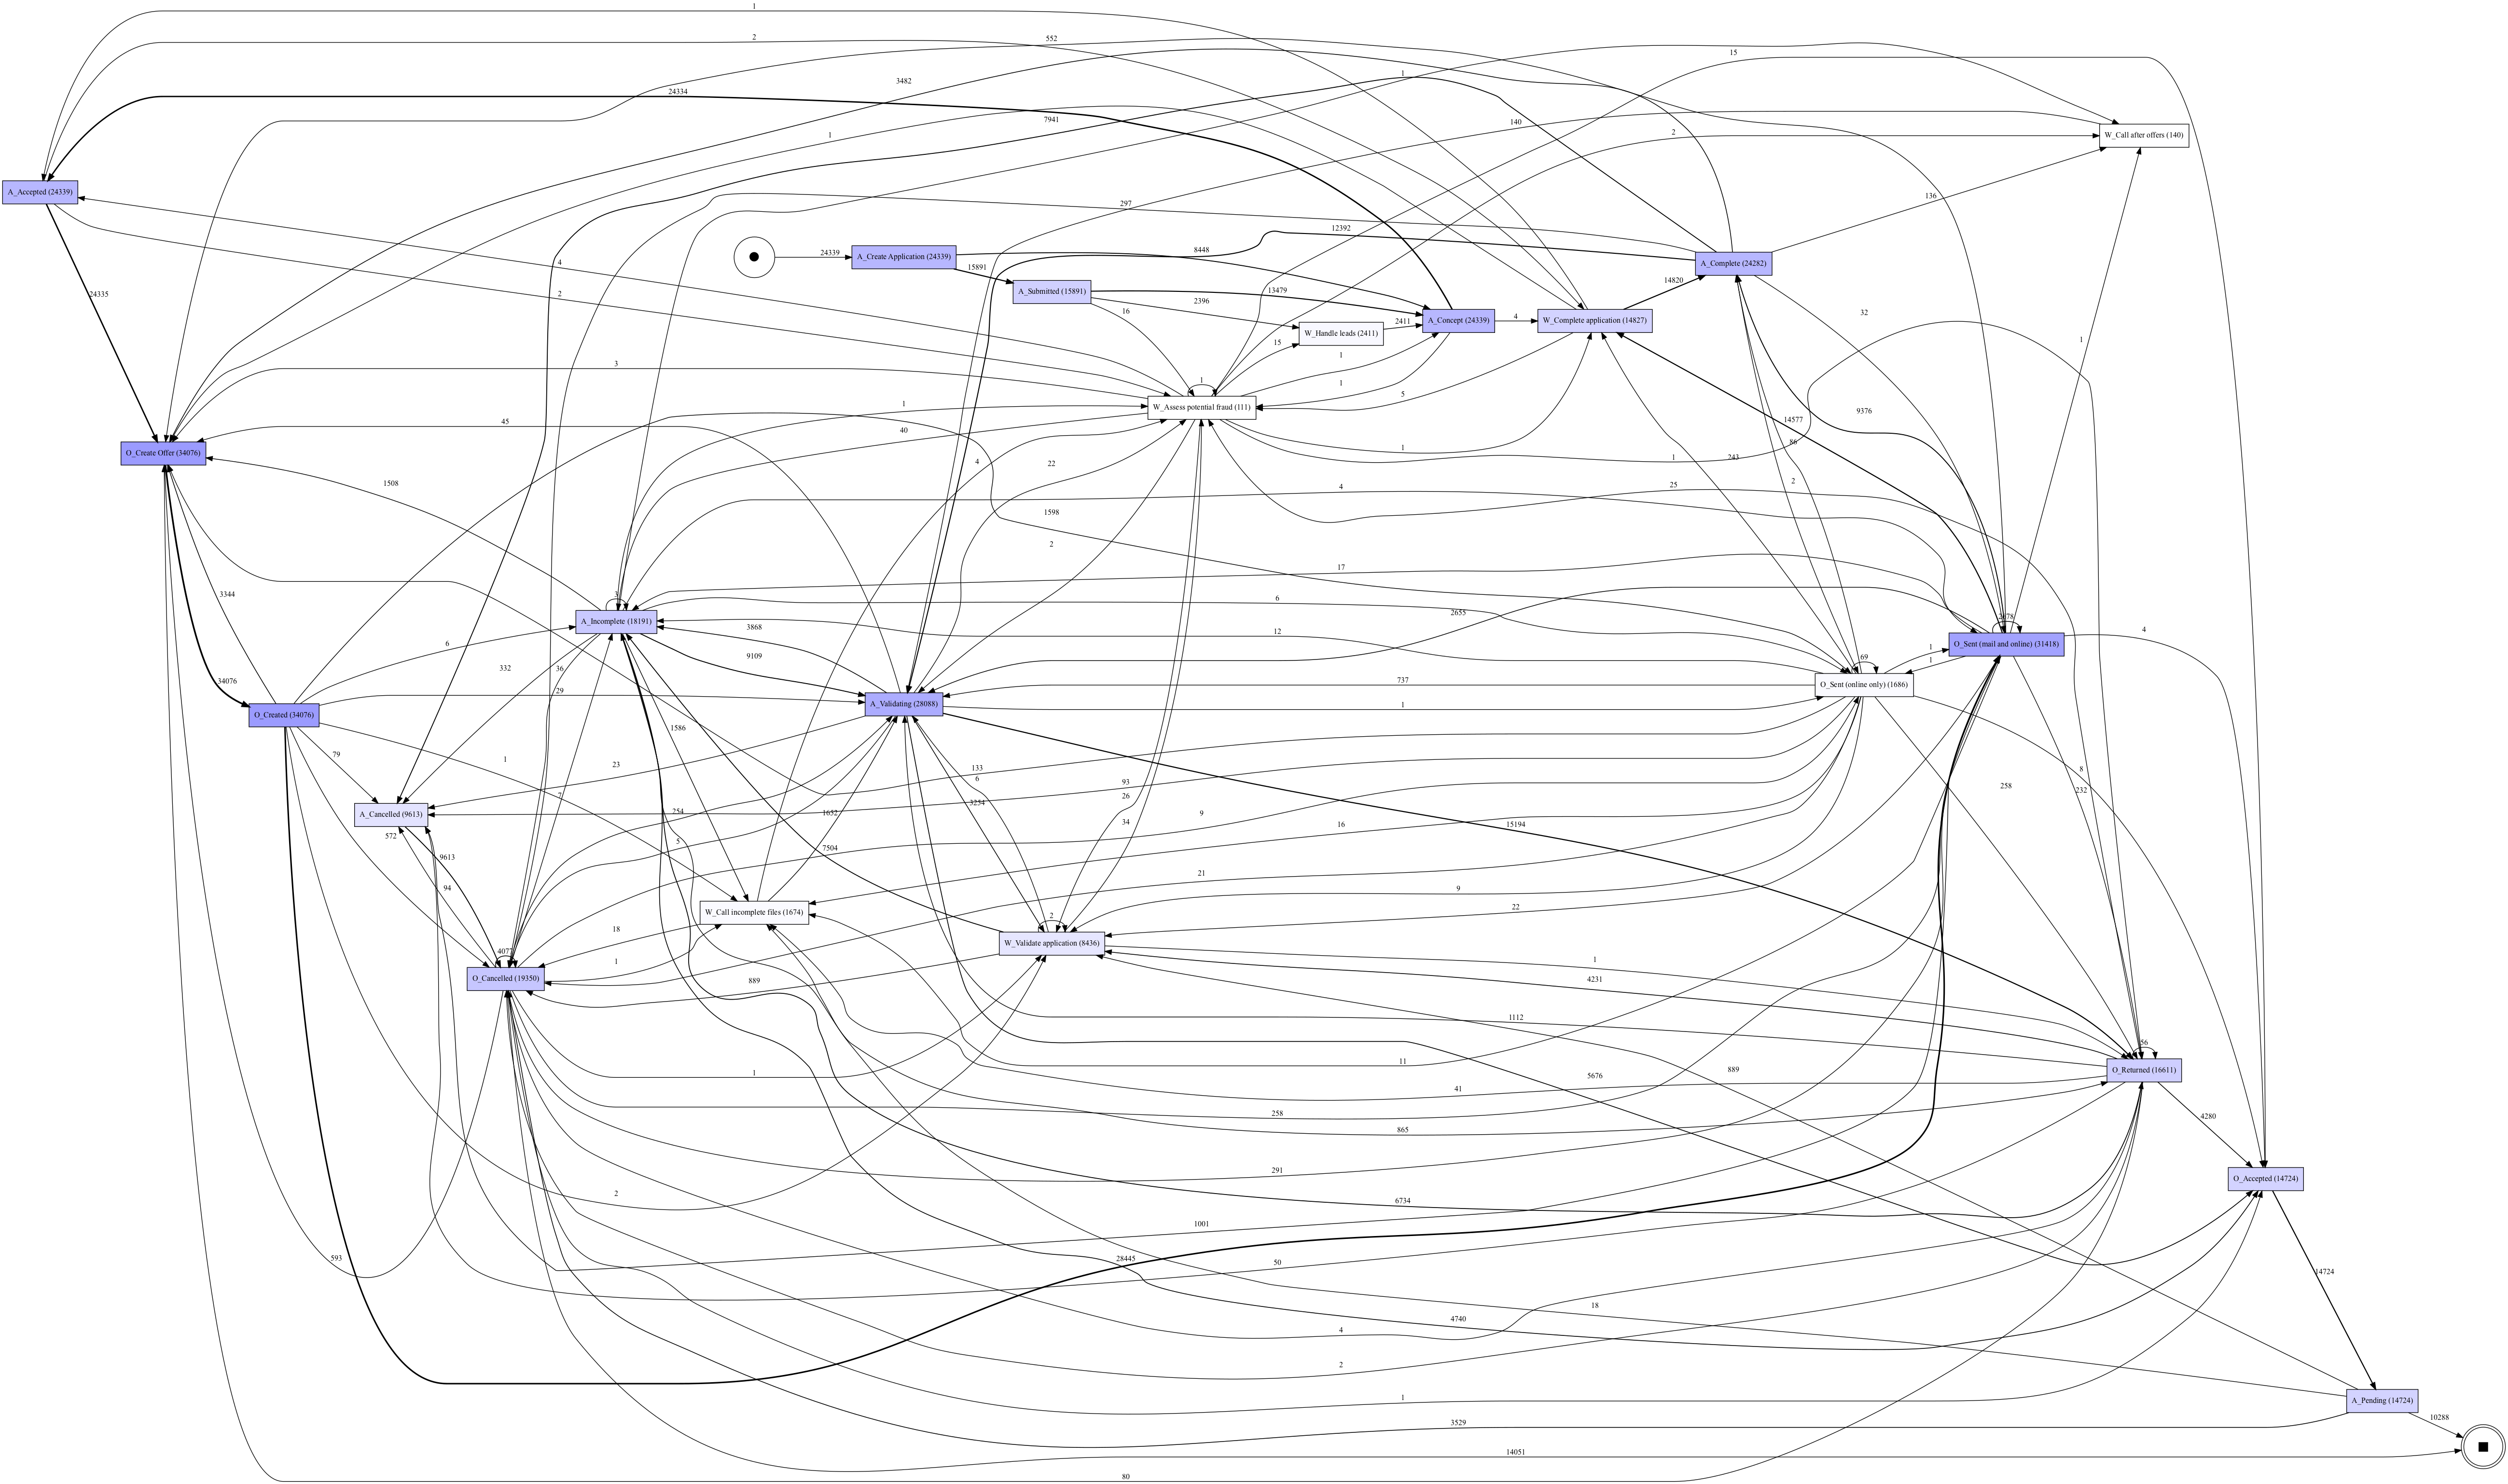

In [14]:
# Directly-Follows Graph
dfg, start_activities, end_activities = pm4py.discover_dfg(filtered_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

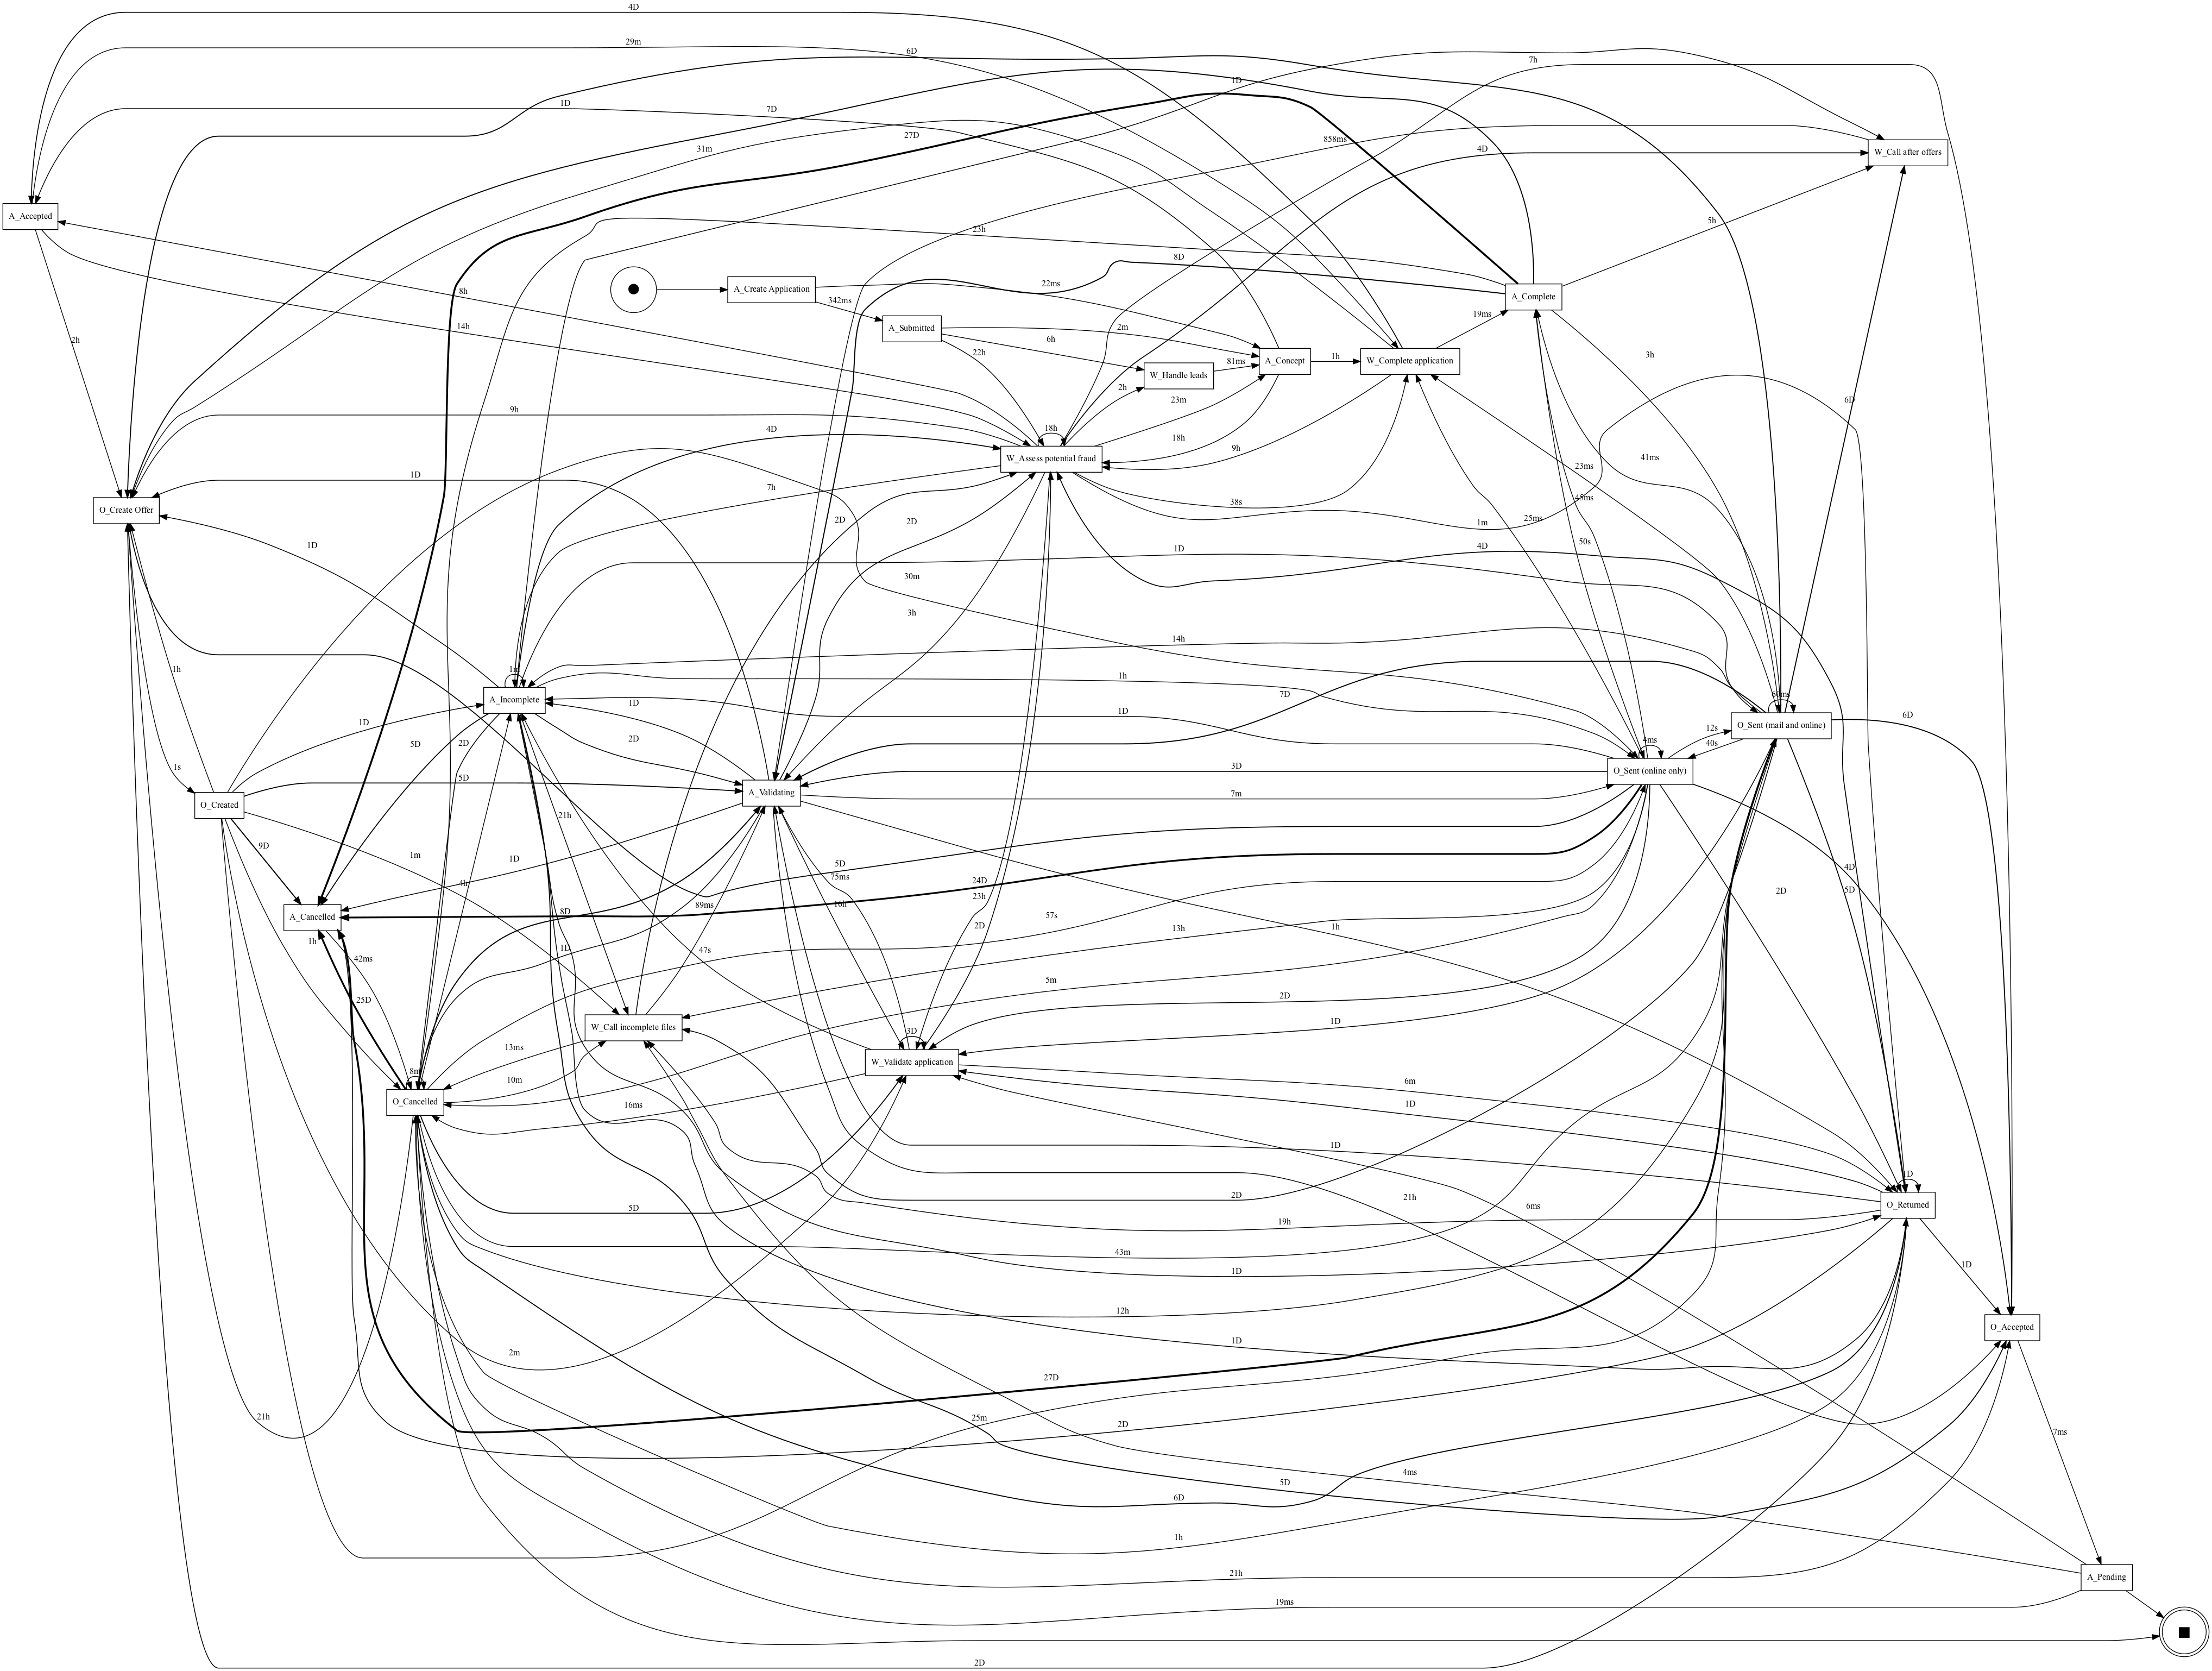

In [15]:
# Directly-Follows graph decorated with the performance(time) between the edges
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(filtered_log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

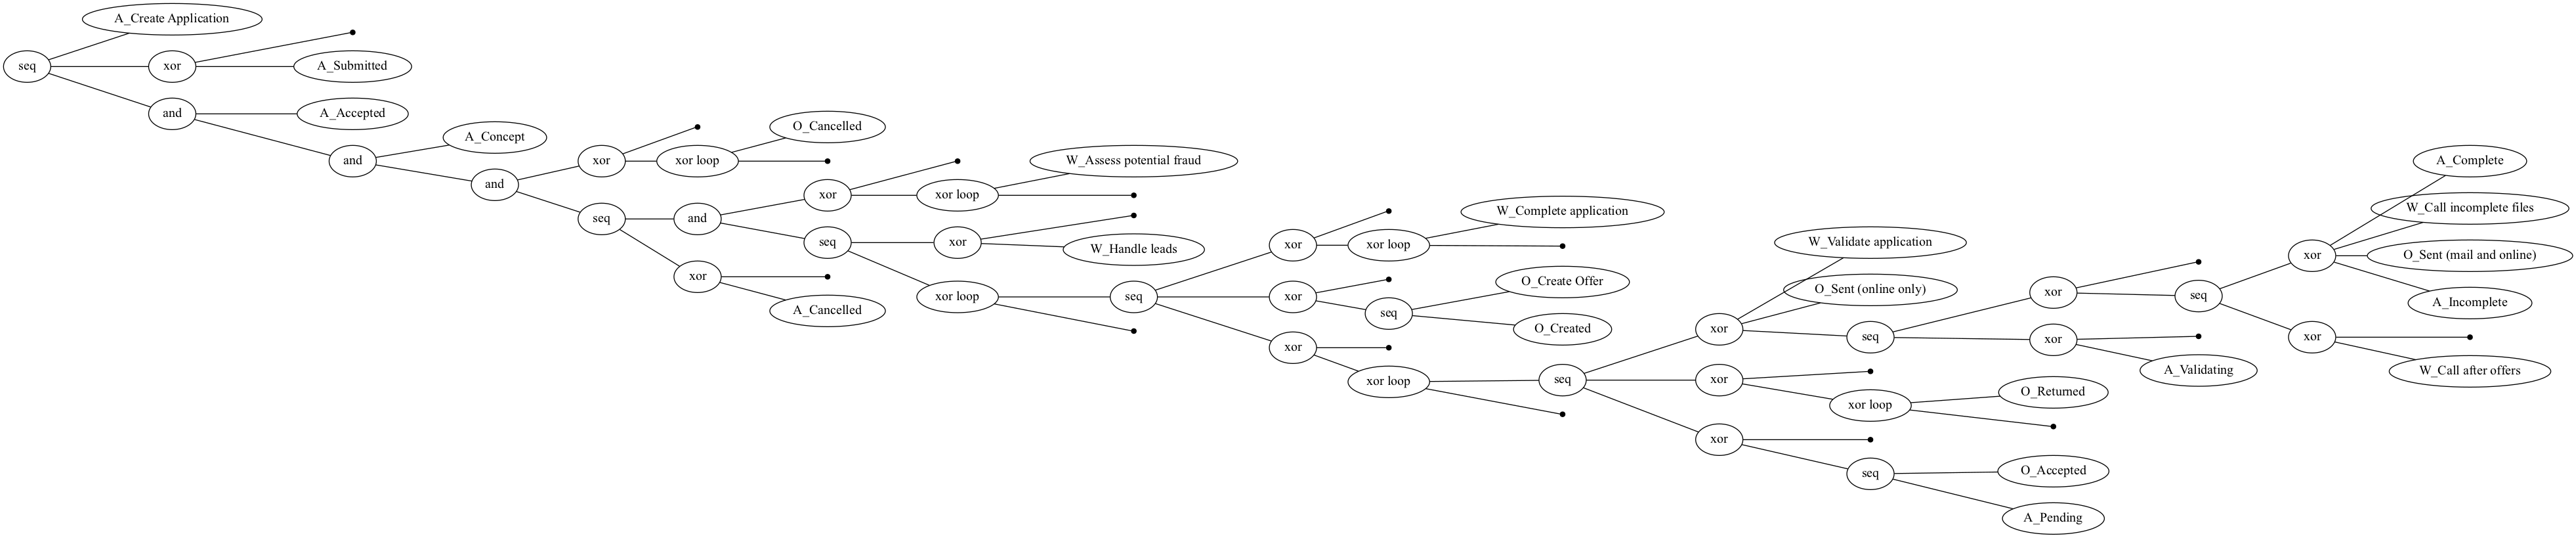

In [16]:
tree = pm4py.discover_process_tree_inductive(filtered_log)

pm4py.view_process_tree(tree)
# I have the difficulty understanding this tree graph

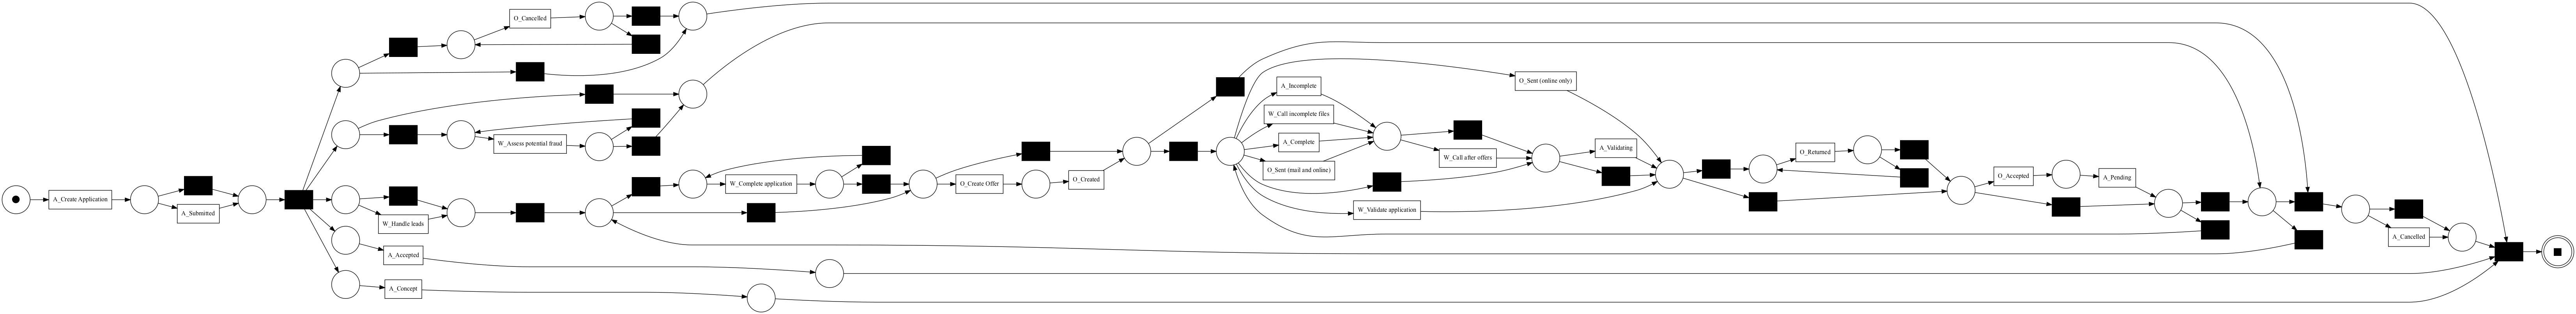

In [17]:
#Inductie Miner
inductive_net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(filtered_log)
pm4py.view_petri_net(inductive_net, initial_marking, final_marking)

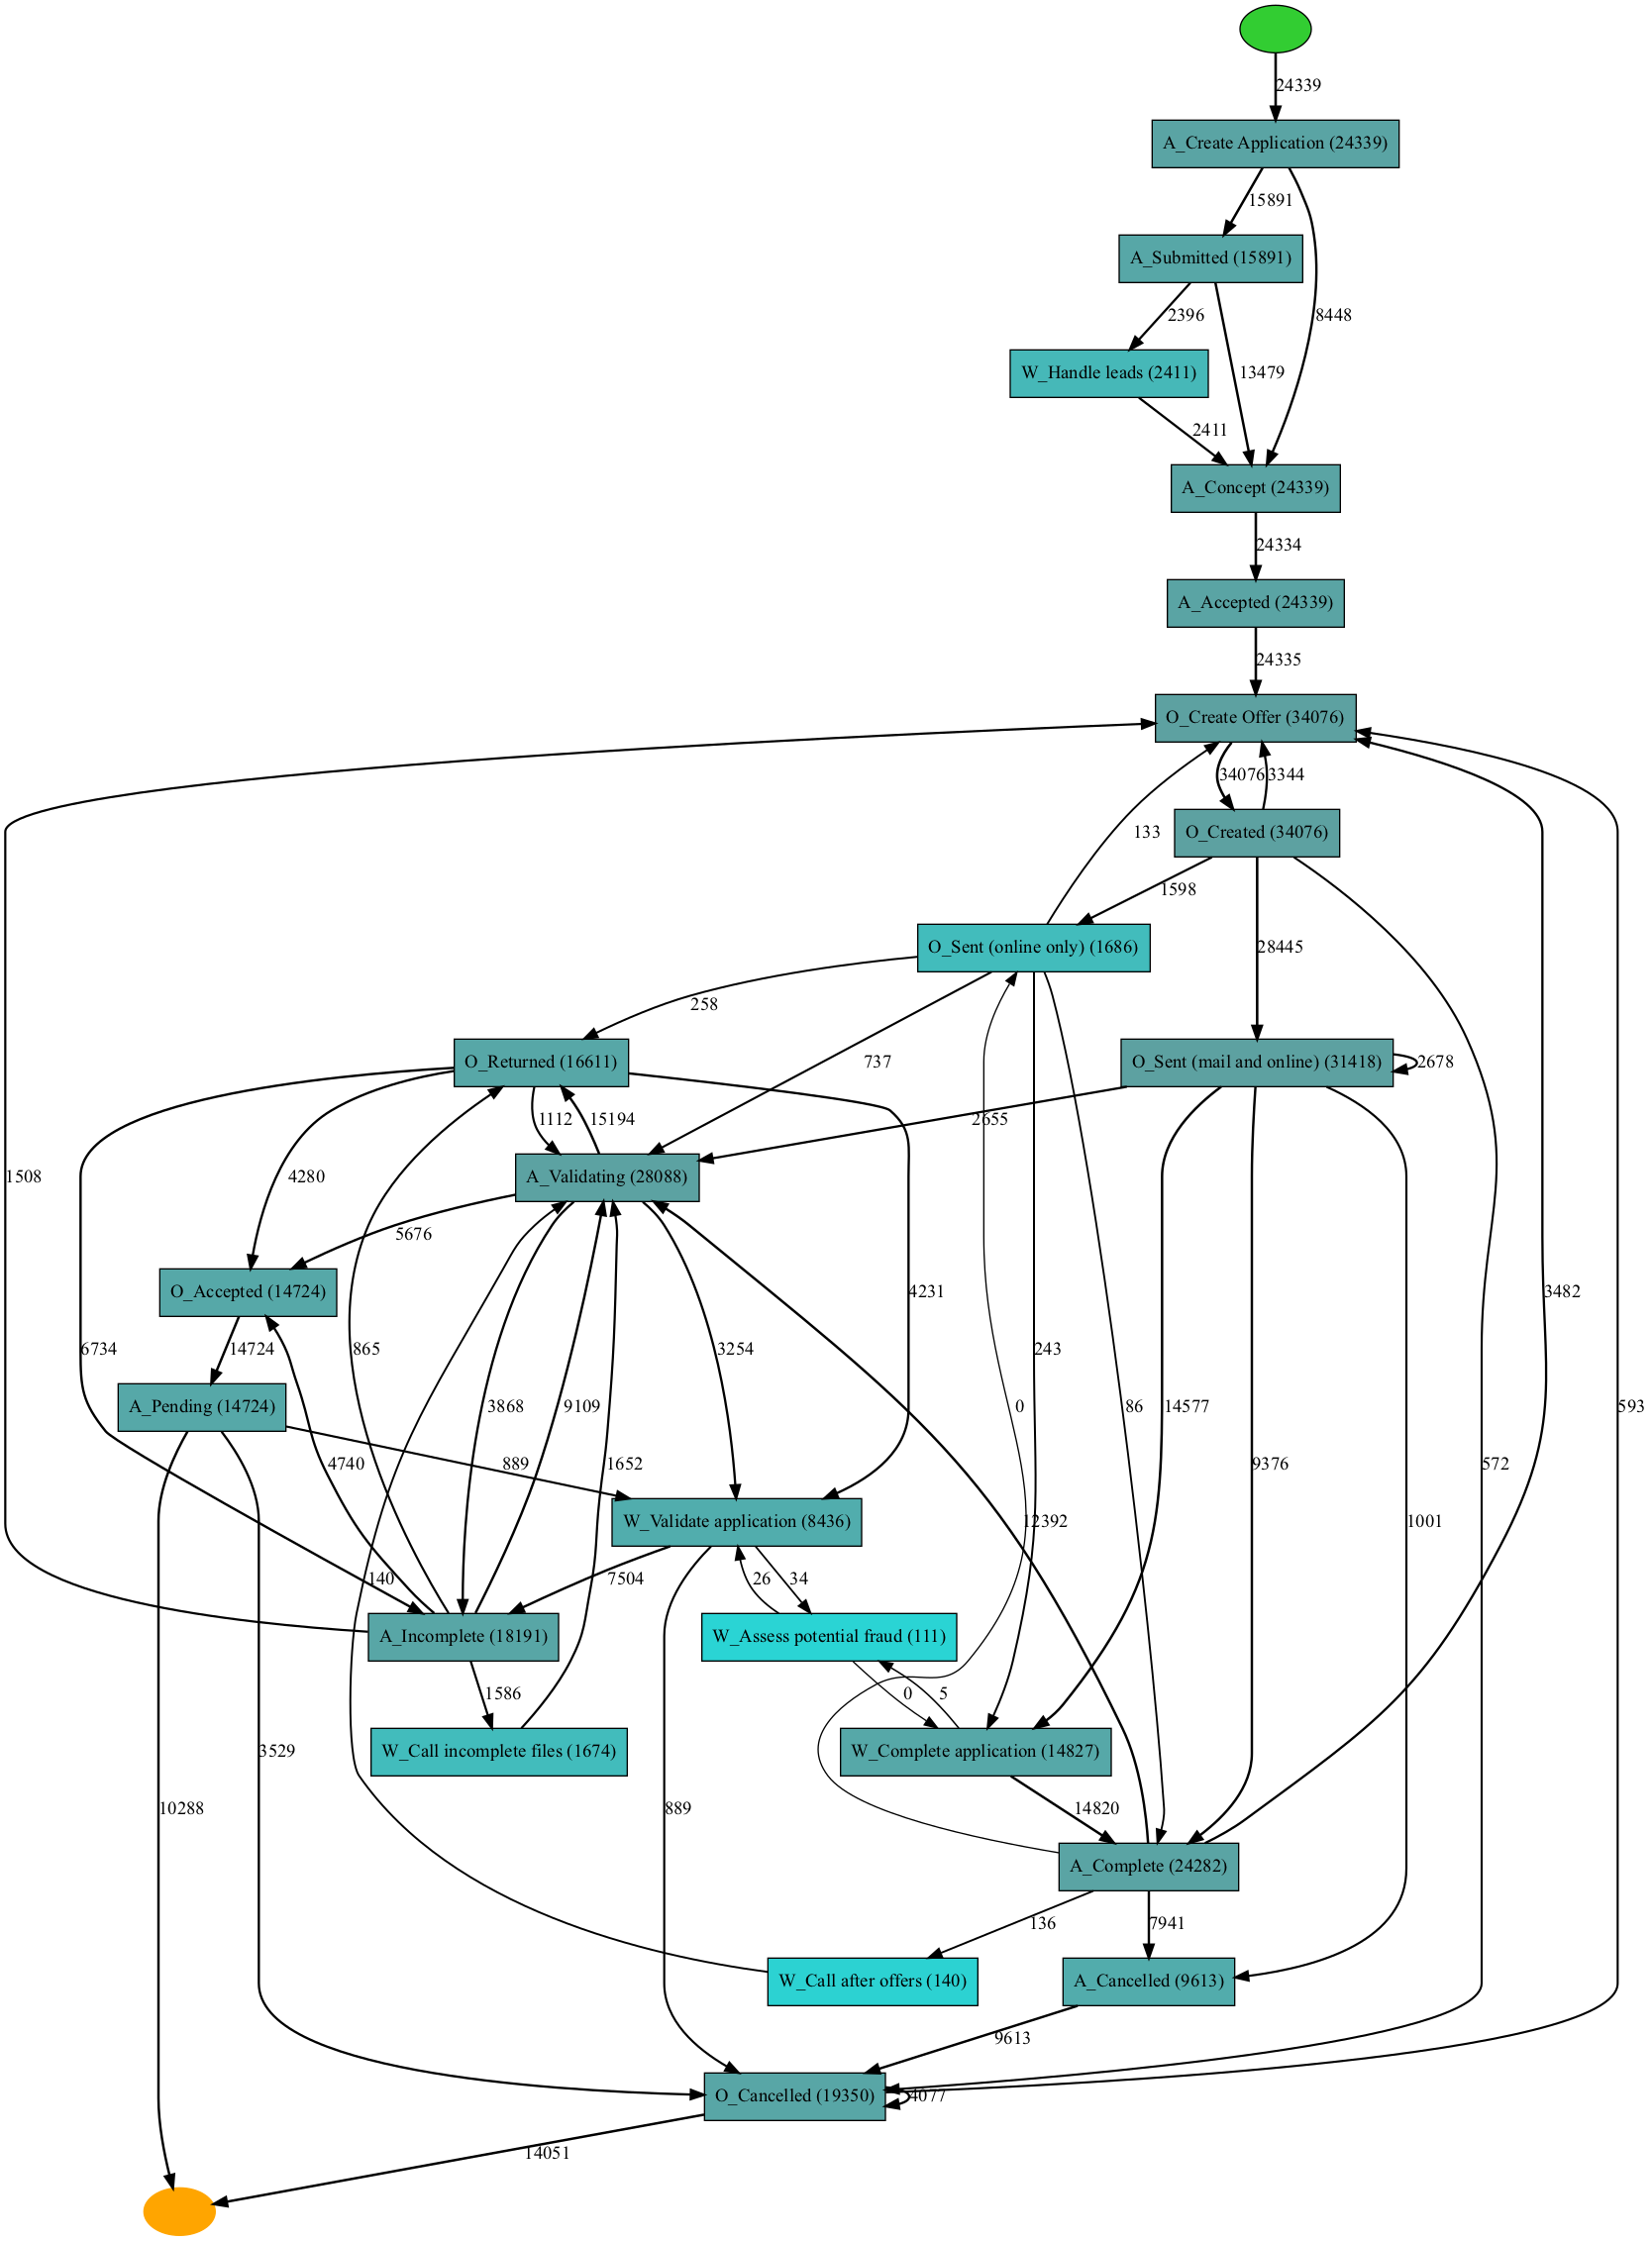

In [18]:
# Heuristic Miner
heu_net = pm4py.discover_heuristics_net(filtered_log, dependency_threshold=0.99)
pm4py.view_heuristics_net(heu_net)

In [19]:
# Use inductive_net we gained one step before to compute fitness
fitness_alignments = pm4py.fitness_alignments(data_raw, inductive_net, initial_marking, final_marking, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
fitness_alignments

aligning log, completed variants ::   0%|          | 0/5623 [00:00<?, ?it/s]

{'percFitTraces': 85.87387730489701,
 'averageFitness': 0.984203910117332,
 'percentage_of_fitting_traces': 85.87387730489701,
 'average_trace_fitness': 0.984203910117332,
 'log_fitness': 0.9837757691308656}

In [20]:
df = pm4py.convert_to_dataframe(data_raw)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475306 entries, 0 to 1202265
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   Action                 475306 non-null  object             
 1   org:resource           475306 non-null  object             
 2   concept:name           475306 non-null  object             
 3   EventOrigin            475306 non-null  object             
 4   EventID                475306 non-null  object             
 5   lifecycle:transition   475306 non-null  object             
 6   time:timestamp         475306 non-null  datetime64[ns, UTC]
 7   case:LoanGoal          475306 non-null  object             
 8   case:ApplicationType   475306 non-null  object             
 9   case:concept:name      475306 non-null  object             
 10  case:RequestedAmount   475306 non-null  float64            
 11  FirstWithdrawalAmount  42995 non-null 

In [35]:
df

Action org:resource              concept:name  EventOrigin  \
0            Created       User_1      A_Create Application  Application   
1        statechange       User_1               A_Submitted  Application   
5        statechange       User_1                 A_Concept  Application   
8        statechange      User_52                A_Accepted  Application   
9            Created      User_52            O_Create Offer        Offer   
...              ...          ...                       ...          ...   
1202256  statechange      User_96  O_Sent (mail and online)        Offer   
1202257      Deleted      User_96    W_Complete application     Workflow   
1202260  statechange      User_96                A_Complete  Application   
1202264  statechange      User_28               A_Cancelled  Application   
1202265  statechange      User_28               O_Cancelled        Offer   

                       EventID lifecycle:transition  \
0        Application_652823628             complete   
1         ApplState_1582051990             complete   
5          ApplState_642383566             complete   
8           ApplState_99568828             complete   
9              Offer_148581083             complete   
...                        ...                  ...   
1202256  OfferState_1959881309             complete   
1202257      Workitem_22300685             complete   
1202260   ApplState_1120616436             complete   
1202264   ApplState_1869071797             complete   
1202265   OfferState_420066181             complete   

                          time:timestamp           case:LoanGoal  \
0       2016-01-01 09:51:15.304000+00:00  Existing loan takeover   
1       2016-01-01 09:51:15.352000+00:00  Existing loan takeover   
5       2016-01-01 09:52:36.413000+00:00  Existing loan takeover   
8       2016-01-02 11:23:04.299000+00:00  Existing loan takeover   
9       2016-01-02 11:29:03.994000+00:00  Existing loan takeover   
...                                  ...                     ...   
1202256 2017-01-02 19:27:20.453000+00:00        Home improvement   
1202257 2017-01-02 19:27:20.465000+00:00        Home improvement   
1202260 2017-01-02 19:27:20.474000+00:00        Home improvement   
1202264 2017-01-16 09:51:21.114000+00:00        Home improvement   
1202265 2017-01-16 09:51:21.139000+00:00        Home improvement   

        case:ApplicationType       case:concept:name  case:RequestedAmount  \
0                 New credit   Application_652823628               20000.0   
1                 New credit   Application_652823628               20000.0   
5                 New credit   Application_652823628               20000.0   
8                 New credit   Application_652823628               20000.0   
9                 New credit   Application_652823628               20000.0   
...                      ...                     ...                   ...   
1202256           New credit  Application_1350494635               20000.0   
1202257           New credit  Application_1350494635               20000.0   
1202260           New credit  Application_1350494635               20000.0   
1202264           New credit  Application_1350494635               20000.0   
1202265           New credit  Application_1350494635               20000.0   

         FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
0                          NaN            NaN      NaN          NaN      NaN   
1                          NaN            NaN      NaN          NaN      NaN   
5                          NaN            NaN      NaN          NaN      NaN   
8                          NaN            NaN      NaN          NaN      NaN   
9                      20000.0           44.0     True       498.29     True   
...                        ...            ...      ...          ...      ...   
1202256                    NaN            NaN      NaN          NaN      NaN   
1202257                    NaN            NaN 

In [47]:
def aggregated_encoding_last(df, case_id='case:concept:name', timestamp='time:timestamp', activity='concept:name'):
    df_sorted = df.sort_values(by=[case_id, timestamp])
    
    activity_counts = pd.pivot_table(df, index=case_id, columns=activity, aggfunc='size', fill_value=0)
    activity_counts = pd.pivot_table(df, index='case:concept:name', columns='concept:name', aggfunc='size', fill_value=0)
    activity_counts.drop(['A_Pending', 'O_Cancelled'],axis=1,inplace=True)
    activity_counts.columns = [f'activity_{activity}_count' for activity in activity_counts.columns]

    aggregated_data = data_raw.groupby(case_id).agg(
        total_duration=pd.NamedAgg(column=timestamp, aggfunc=lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds()),
        avg_time_between_events=pd.NamedAgg(column=timestamp, aggfunc=lambda x: (x.diff().dropna().mean().total_seconds())),
        unique_offered_amounts=pd.NamedAgg(column='OfferedAmount', aggfunc=lambda x: list(x.dropna().unique())),
        total_events=pd.NamedAgg(column='concept:name', aggfunc='count'),
        avg_requested_amount=pd.NamedAgg(column='case:RequestedAmount', aggfunc='mean'),
        max_offered_amount=pd.NamedAgg(column='OfferedAmount', aggfunc='max'),
    ).reset_index()
    # Determine the last activity for each case
    last_activity = df_sorted.groupby(case_id)[activity].last().reset_index()
    last_activity['Label'] = last_activity[activity] == 'A_Pending'

    # Merge the activity counts with the aggregated data
    aggregated_data = pd.merge(aggregated_data, activity_counts, on=case_id)
    
    # Merge the 'Label' information back onto the 'aggregated_data' DataFrame
    aggregated_data = pd.merge(aggregated_data, last_activity[[case_id, 'Label']], on=case_id)


    
    data=pd.DataFrame(aggregated_data)
    return data

In [48]:
aggregated_encoding_last(df) #is list with offered amounts ok?

case:concept:name  total_duration  avg_time_between_events  \
0      Application_1000086665     2815395.156            312821.684000   
1      Application_1000158214      694054.434             57837.869500   
2      Application_1000311556     2642651.275            293627.919444   
3      Application_1000334415     1177576.622             78505.108133   
4      Application_1000339879     1109678.437             58404.128263   
...                       ...             ...                      ...   
31504   Application_999507989      544475.733             45372.977750   
31505   Application_999544538     6893315.307            196951.865914   
31506   Application_999632431     2745334.302            274533.430200   
31507   Application_999993467     1190562.772             74410.173250   
31508   Application_999993812     1528045.960            127337.163333   

      unique_offered_amounts  total_events  avg_requested_amount  \
0                   [5000.0]            10                5000.0   
1                  [12500.0]            13               12500.0   
2                  [45000.0]            10               45000.0   
3                   [5000.0]            16                5000.0   
4                  [37500.0]            20               37500.0   
...                      ...           ...                   ...   
31504              [24000.0]            13               24000.0   
31505              [50000.0]            36               50000.0   
31506              [12000.0]            11               12000.0   
31507     [10000.0, 15000.0]            17               10000.0   
31508              [30000.0]            13               30000.0   

       max_offered_amount  activity_A_Accepted_count  \
0                  5000.0                          1   
1                 12500.0                          1   
2                 45000.0                          1   
3                  5000.0                          1   
4                 37500.0                          1   
...                   ...                        ...   
31504             24000.0                          1   
31505             50000.0                          1   
31506             12000.0                          1   
31507             15000.0                          1   
31508             30000.0                          1   

       activity_A_Cancelled_count  activity_A_Complete_count  ...  \
0                               1                          1  ...   
1                               0                          1  ...   
2                               1                          1  ...   
3                               0                          1  ...   
4                               0                          1  ...   
...                           ...                        ...  ...   
31504                           0                          1  ...   
31505                           0                          1  ...   
31506                           1                          1  ...   
31507                           0                          1  ...   
31508                           0                          1  ...   

       activity_O_Returned_count  activity_O_Sent (mail and online)_count  \
0                              0                                        1   
1                              1                                        1   
2                              0                                        1   
3                              1                                        1   
4                              1                                        1   
...                          ...                                      ...   
31504                          1                                        1   
31505                          2                                        4   
31506                          0                                        1   
31507                          1  